# AI in Finance SVM Project



## ABSTRACT
This project demonstrates an implementation of the walking-forward approach into the support vector machine (SVM) model, in order to train the algorithm to make weekly trading decisions based on financial indicators and past price data. The inputs are subsets taken from intraday Kibot price data of US NYSE SPY in the range 2016-04 to 2018-12, on half-hour intervals between 9:30AM to 4:00PM daily of each trading days. Using a walking-forward harness, the model is trained weekly with five features (RSI_diff, RSI_SMA_10_diff, close-1-SAR, OO, OC) based on previous 260 data points, and outputs trading decisions for the future week. The model uses a trading strategy such that it makes buying decisions for the highest 30% of the signal’s quantile, does nothing for the middle 40% of the quantile, and sells for lowest 30% of the quantile. 
\
\
Resulting model predictions have an accuracy of 0.4 and precision for sell signals of 0.49; its decisions result in a Sharpe ratio of 4.98 indicating satisfactory returns. Although this result fails the White's reality check, the margin is slim. The high precision of call signals and the equity curve shows that the model is able to cature the major downtrend of the slow-bull market. Compared to the results of dummy classifier with Sharpe ratio of 0.44 and p-value of 0.67, we conclude that the SVM model would survive the market correction at the end of 2018.

## DATA CREATION 

This section processes raw Kibot price data, creating appropriate input signals for SVM with the following manipulations:
*   Library and Module Importing
*   Data Cleaning: drops data points of no trading volume, converts date formats
*   Financial Indicator Calculation
*   Data Trimming: drops data points with NaN values
*   Trading Signal Generation: splits return signals to 0.4:0.2:0.4 percentiles that corresponds to buy:hold:sell
*   Feature Selection: keeps only 5 features: RSI_diff, RSI_SMA_10_diff, close-1-SAR, OO, OC

### Library and Module Importing

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.dummy import DummyClassifier
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from datetime import datetime as dt
import detrendPrice
import WhiteRealityCheckFor1
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
import itertools

In [ ]:
# url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
# !wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
# !wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
# !dpkg -i libta.deb ta.deb
# !pip install ta-lib
import talib as ta

### Data Cleaning



In [ ]:
Df = pd.read_csv('SPY_all_kibot.csv') 
Df.drop(['Ticker'],axis='columns',inplace=True)

In [ ]:
Df=Df.drop(Df[Df['Volume']==0].index)

In [ ]:
Df['Time']=pd.to_datetime(Df['Time'],format='%H:%M').dt.time

In [ ]:
#select data in range 2016-04 and 2018-12
Df['Date']=pd.to_datetime(Df['Date'])
Df = Df.loc[(Df['Date'] >= '2016-04-01') & (Df['Date'] <= '2018-12-31')]
Df = Df.reset_index(drop=True)

In [ ]:
#select regular trading hours
Df = Df[Df['Time'] >= dt.strptime('9:30','%H:%M').time()]
Df = Df[Df['Time'] <= dt.strptime('16:00','%H:%M').time()]

In [ ]:
Df['date_Time'] = Df['Date'].astype(str)+' '+ Df['Time'].astype(str)
Df['date_Time'] = pd.to_datetime(Df['date_Time'])

In [ ]:
Df.set_index('date_Time', inplace = True)

In [ ]:
#determine ratio of the data for generating signals
t=.8
split = int(t*len(Df))

### Financial Indicator Creation

Lookback window

In [ ]:
n=15 #this is the window for return periods (among other things)

In [ ]:
#RSI indicator
Df['RSI']=ta.RSI(np.array(Df['Close'].shift(1)), timeperiod=n)
#RSI - last period's RSI
Df['RSI_diff'] = Df['RSI'] - Df['RSI'].shift(1)

#RSI - SMA(RSI,10)
Df['RSI_SMA_10_diff'] = Df['RSI'].shift(1)-Df['RSI'].shift(1).rolling(window=10).mean()

In [ ]:
#SMA(15)
Df['SMA'] = Df['Close'].shift(1).rolling(window=n).mean()

#Corr(Close, SMA(15))
Df['Corr']=Df['Close'].shift(1).rolling(window=n).corr(Df['SMA'].shift(1))

SAR and ADX are calculated on High and Low prices because they are intended to be sensitive to new "Highs" and "Lows" created. In the SAR indicator the values of 0.2 represent the acceleration and maximum step parameters. These are just default values agreed upon by tradition. see:https://www.investopedia.com/terms/p/parabolicindicator.asp 

In [ ]:
Df['SAR']=ta.SAR(np.array(Df['High'].shift(1)),np.array(Df['Low'].shift(1)),\
                  0.2,0.2)
Df['ADX']=ta.ADX(np.array(Df['High'].shift(1)),np.array(Df['Low'].shift(1)),\
                  np.array(Df['Open']), timeperiod =n)

#SAR - last period's SAR
Df['close-1-SAR']=Df['Close'].shift(2)-Df['SAR']

We will pass yesterday's "High", "Low", and "Close" prices as input to the algorithm in variables named in lower cases. This will help the algorithm sense the volatility of the past time period.

In [ ]:
Df['close'] = Df['Close'].shift(1)
Df['high'] = Df['High'].shift(1)
Df['low'] = Df['Low'].shift(1)

We will also pass two other values as features: the change in "Open" prices between yesterday and today & the difference between today's "Open" and yesterday's "Close" prices.

In [ ]:
Df['OO']= Df['Open']-Df['Open'].shift(1)
Df['OC']= Df['Open']-Df['close']

Next, calculate the returns for every data point and save in "Ret".

In [ ]:
Df['Ret']=np.log(Df['Open'].shift(-1)/Df['Open'])

### Data Trimming

We would like to keep the values of indicator ‘Corr’ between -1 and 1, as the correlation coefficient is always between these values. This is done by changing all values less than -1 to -1, and all values greater than 1 to 1. This doesn’t affect our calculations negatively because the extreme values are realised due to NAN values in the data, which need to be handled before training the algorithm. Then we drop all NANs from the entire dataframe.

In [ ]:
#the correlation function used above to generate the Df['Corr'] column
#should not be generating any values outside -1 and 1; 
#however, something is going on that makes the function generate infinite or NAN values sometimes and
#we have to get rid of these errors

Df.loc[Df['Corr']<-1,'Corr']=-1
Df.loc[Df['Corr']>1,'Corr']=1
Df=Df.dropna()

### Trading Signal Generation

Next, we assign signal values corresponding to ‘returns’ that were calculated earlier. To do this, we split the data into three parts, as per the returns. The highest 30% returns are assigned Signal ‘1’ or “Buy”. Lowest 30% returns are assigned Signal ‘-1’ or ‘Sell’. Others are assigned ‘0’ or ‘Do Nothing’

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EAA4E6CB48>]],
      dtype=object)

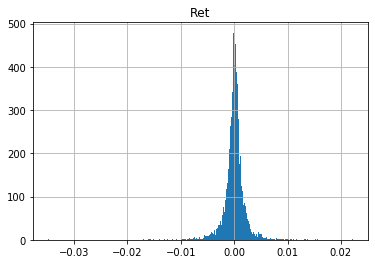

In [ ]:
Df.hist(["Ret"], bins=500)

In [ ]:
Df['Ret'].describe()

count    9671.000000
mean        0.000026
std         0.001987
min        -0.034805
25%        -0.000680
50%         0.000073
75%         0.000776
max         0.022196
Name: Ret, dtype: float64

In [ ]:
Df['Signal']=0
Df.loc[Df['Ret']>Df['Ret'][:split].quantile(q=0.7),'Signal']=1
Df.loc[Df['Ret']<Df['Ret'][:split].quantile(q=0.3),'Signal']=-1

In [ ]:
Df['Signal'].value_counts()

 0    3657
-1    3037
 1    2977
Name: Signal, dtype: int64

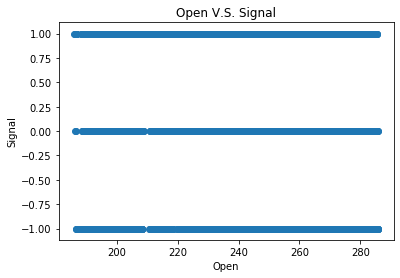

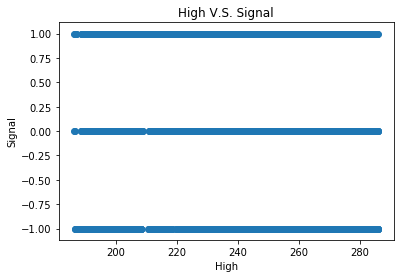

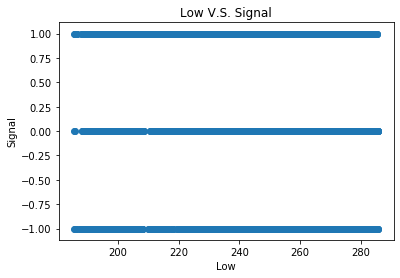

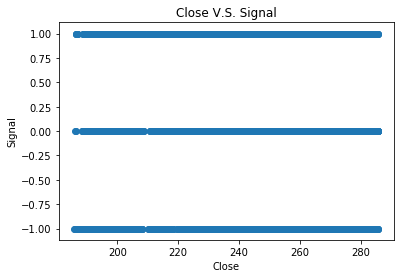

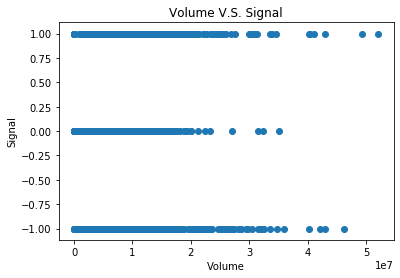

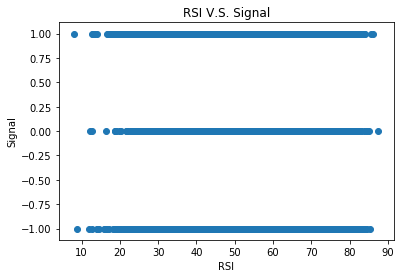

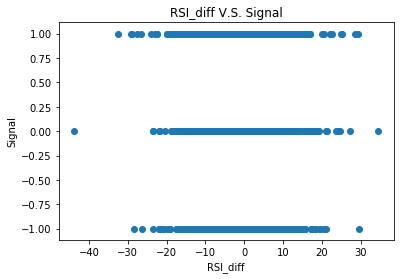

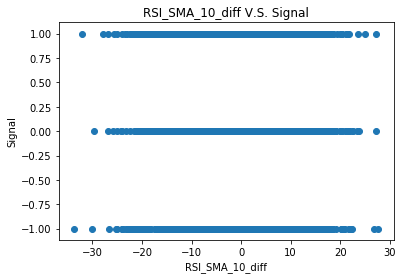

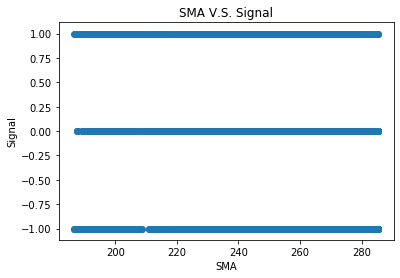

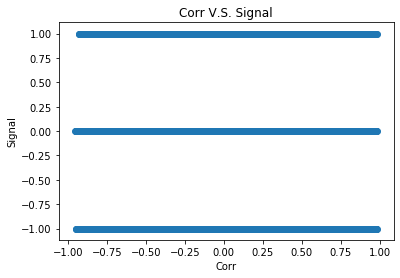

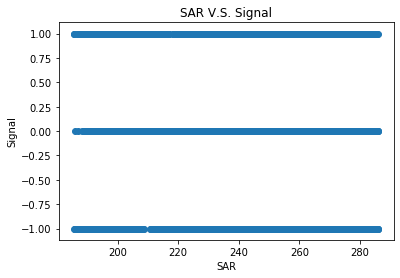

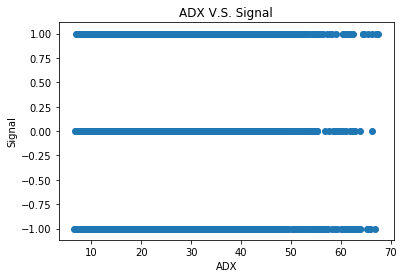

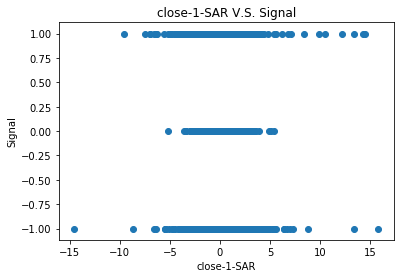

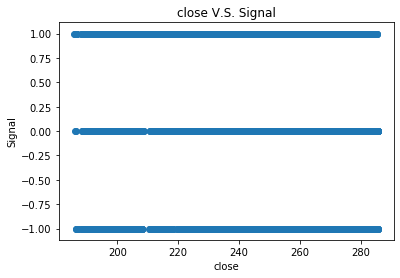

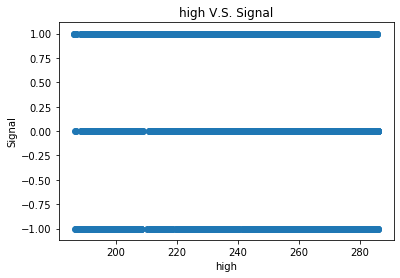

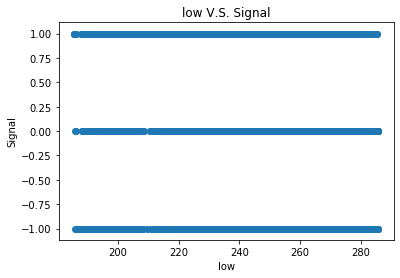

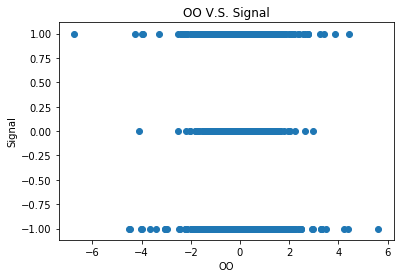

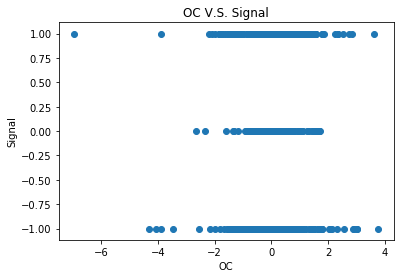

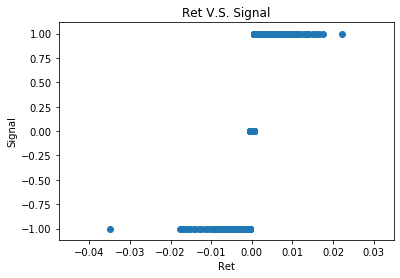

In [ ]:
cols = Df.columns
for col in cols[2:len(cols)-1]:
    plt.scatter(Df[col], Df["Signal"])
    plt.title(col + " V.S. Signal")
    plt.xlabel(col)
    plt.ylabel("Signal")
    plt.show()

In [ ]:
def plot2D(df, col1, col2):
    plt.scatter(df[col1], df[col2], c=df.Signal)
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title("Signal by " + col1 + " and " + col2)
    plt.show()

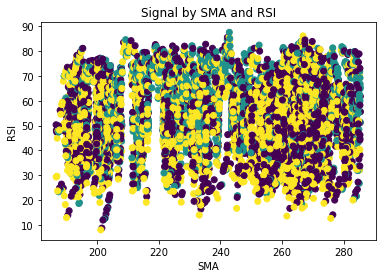

In [ ]:
plot2D(Df, "SMA", "RSI")

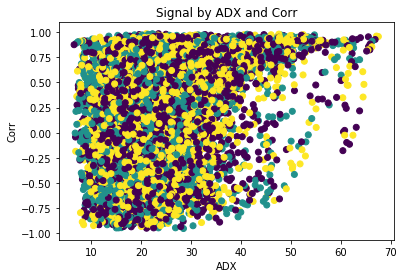

In [ ]:
plot2D(Df, "ADX", "Corr")

One last step and then we will be ready with our data!  
### Feature Selection

We are dropping most of the features since the algorithm will not be trained on these features. Next, we assign ‘Signal’ to ‘y’ which is the output variable that we will predict using test data.   

In [ ]:
y=Df['Signal']
X=Df.drop(['Date','Open', 'SMA', 'RSI','SAR','ADX', 'Close','Signal','Time','High','Low','Ret','close','high','low', 'Corr', 'Volume'],axis=1)

In [ ]:
X.head()

,RSI_diff,RSI_SMA_10_diff,close-1-SAR,OO,OC
date_Time,,,,,
2016-04-05 10:30:00,6.189888,-25.153955,-1.580000,0.43,0.00
2016-04-05 11:00:00,-5.622880,-15.708552,-0.752000,-0.57,0.00
2016-04-05 11:30:00,4.136932,-17.464287,-1.003600,0.31,0.00
2016-04-05 12:00:00,-1.855751,-10.411349,-0.438880,-0.18,0.01
2016-04-05 12:30:00,-1.911158,-9.831751,-0.425104,-0.22,-0.01


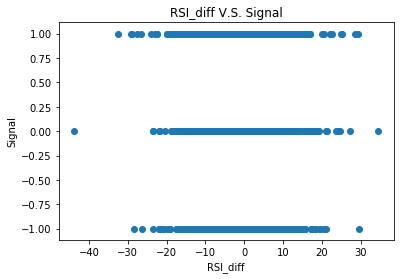

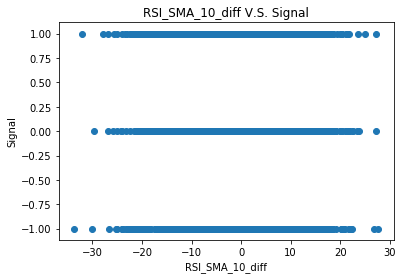

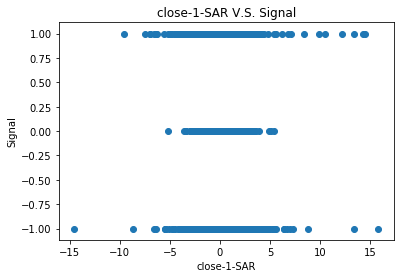

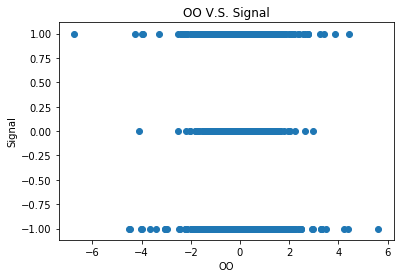

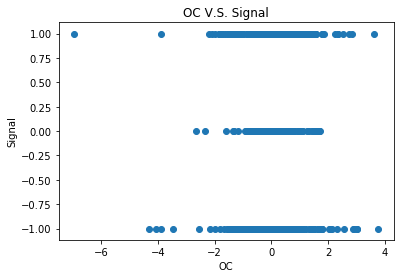

In [ ]:
cols = X.columns
for col in cols:
    plt.scatter(X[col], y)
    plt.title(col + " V.S. Signal")
    plt.xlabel(col)
    plt.ylabel("Signal")
    plt.show()

In [ ]:
def plot2D_new(X, y, feature1, feature2):
    X2D = X[[feature1, feature2]]
    X2D_arr=X2D.values
    y_arr=y.values
    %matplotlib inline
    plt.figure(figsize=(5, 5))
    plt.scatter(X2D_arr[:, 0], X2D_arr[:, 1], c=y_arr)
    plt.title("Class by " + feature1 + " and " + feature2)
    plt.xlabel(feature1)
    plt.ylabel(feature2)

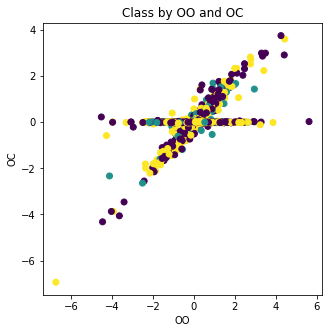

In [ ]:
plot2D_new(X,y,"OO", "OC")

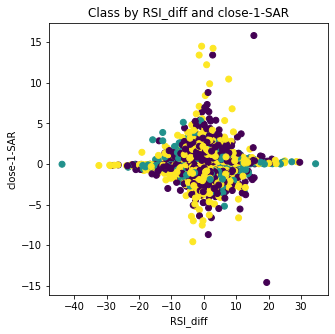

In [ ]:
plot2D_new(X,y,'RSI_diff','close-1-SAR')

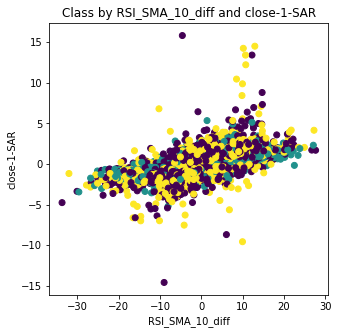

In [ ]:
plot2D_new(X,y,'RSI_SMA_10_diff','close-1-SAR')

## SVM

This section contains the class that implements the walking-forward harness to a support vector machine (SVM) model with the following considerations:
*   model performs on data sets from 2018-08 to 2018-12, the market correction!
*   training data is rolled in 260 every week
*   model outputs decisions the entire future trading week, every week
*   input features and strategies as defined above

Results of this model evaluated by the following metrics and comparisons:

*   resulting precision, recall, f1-score, and support of the estimator's hyperparameters using grid-search to qualify the performance of the model
*   market returns, model returns, Sharpe ratio, White's Reality Check, and p-value to quantify the performance of the model

In [ ]:
class SVCModel(object):
    def __init__(self, combo):
        
        self.df_result = pd.DataFrame(columns=['Actual', 'Predicted'])
        self.combo = combo

    def learn(self, df, ys, start_date, end_date, lookback_period):
        
        model = SVC(C=self.combo[0], gamma=self.combo[1], tol=1e-3, max_iter=300, kernel="rbf", class_weight="balanced")
        
        date_index = df["2012":end_date].index
        freq_start = pd.to_datetime(start_date) 
        date_range = pd.date_range(start=freq_start, end=end_date,freq='1W') 
        
        for i in range(len(date_range)-1):
            
            # get data
            date = date_range[i]
            train_time = pd.to_datetime(str(date) + ' ' + '16:00') 
            train_time_index = len(date_index[date_index <= train_time])
            x = self.get_prices_since(df, train_time_index, lookback_period) 
            y = self.get_prices_since(ys, train_time_index, lookback_period) 
            x = np.array(x)
            y = np.array(y)
            scaler = StandardScaler()
            x = scaler.fit_transform(x)
            
            # fit model
            model.fit(x, y.ravel())
            
            # predict the next week       
            pred_time_end = pd.to_datetime(str(date_range[i+1]) + ' ' + '16:00') 
            pred_time_index = len(date_index[date_index <= pred_time_end])
            x_current = np.array(df.iloc[train_time_index : pred_time_index].values)
            y_pred = model.predict(scaler.transform(x_current))

            #store predictions
            pred_time = date_index[train_time_index:pred_time_index]
            y_actual = list(ys.loc[pred_time])
            for actual, pred, time in zip(y_actual, y_pred, pred_time):
                self.df_result.loc[time] = [actual, pred]
                
    def get_prices_since(self, df, date_since, lookback):
        return df.iloc[date_since-lookback:date_since]


In [ ]:
def eval_model(model):
    
    #add predicted signal to the dataframe
    df_result = model.df_result
    Df['Pred_Signal'] = 0
    df = Df[START:END]
    df.iloc[:,df.columns.get_loc('Pred_Signal')] = df_result['Predicted']
    df = df.dropna()
    print("====actual signal counts====")
    print(df.Signal.value_counts())
    print("====predicted signal counts====")
    print(df.Pred_Signal.value_counts())
    
    #strategy cumulative return
    df['Ret1'] = df['Ret'] * df['Pred_Signal'] 
    df['Cu_Ret1'] = 0.
    df['Cu_Ret1'] = np.cumsum(df['Ret1'].iloc[:])
    
    #market cumulative return
    df['Cu_Ret']=0.
    df['Cu_Ret']=np.cumsum(df['Ret'].iloc[:])
    
    #calculate strategy sharpe ratio
    sharpe = (df['Cu_Ret1'].iloc[-1]-df['Cu_Ret'].iloc[-1])/np.std(df['Cu_Ret1'])
    
    #plot
    plt.plot(list(df['Cu_Ret1']),color='r',label='Strategy Returns')
    plt.plot(list(df['Cu_Ret']),color='g',label='Market Returns')
    plt.figtext(0.14,0.7,s='Sharpe ratio: %.2f'%sharpe)
    plt.legend(loc='best')
    plt.show()
    
    #whitereality check
    Pred_Signal = np.array(df['Pred_Signal'],dtype = float)
    df['DetOpen'] = detrendPrice.detrendPrice(df['Open']).values
    df['DetRet']=np.log(df['DetOpen'].shift(-1)/df['DetOpen'])
    df['DetStrategy']=df['DetRet']*Pred_Signal
    WhiteRealityCheckFor1.bootstrap(df['DetStrategy'])

### Grid Search

In [ ]:
START = '2018-08'
END = '2018-12'
lookback=260
Df[START:END]['Signal'].value_counts()

-1    566
 1    501
 0    402
Name: Signal, dtype: int64

In [ ]:
Df[START:END]['Ret'].describe()

count    1469.000000
mean       -0.000074
std         0.002968
min        -0.017043
25%        -0.001195
50%         0.000035
75%         0.001028
max         0.016465
Name: Ret, dtype: float64

In [ ]:
c_gs = [0.001, 0.01, 0.1, 1, 10, 100]
g_gs = np.linspace(5,50,5)

In [ ]:
best_accu = 0
best_combo = None

for combo in itertools.product(c_gs, g_gs):
    svc_model = SVCModel(combo)
    svc_model.learn(X, y, start_date=START, end_date=END, lookback_period=lookback)
    df_result = svc_model.df_result
    actual = list(df_result['Actual'])
    predicted = list(df_result['Predicted'])
    curr_accu = accuracy_score(actual, predicted)
    if curr_accu > best_accu:
        best_accu = curr_accu
        best_combo = combo
        
print("best_accuracy: ", best_accu)    
print("best combo: ", best_combo)

best_accuracy:  0.40293040293040294
best combo:  (1, 5.0)


In [ ]:
svc_model = SVCModel(best_combo)
svc_model.learn(X, y, start_date=START, end_date=END, lookback_period=lookback)

In [ ]:
df_result = svc_model.df_result
actual = list(df_result['Actual'])
predicted = list(df_result['Predicted'])

print('accuracy_score:', accuracy_score(actual, predicted))
print('precision_score:', precision_score(actual, predicted,average='macro'))
print('recall_score:', recall_score(actual, predicted,average='macro' ))
print('f1_score:', f1_score(actual, predicted,average='macro')) 
print(classification_report(actual, predicted))

accuracy_score: 0.40293040293040294
precision_score: 0.40087857476716926
recall_score: 0.39884692747877887
f1_score: 0.3974367672133043
              precision    recall  f1-score   support

          -1       0.41      0.49      0.44       397
           0       0.41      0.40      0.41       349
           1       0.38      0.31      0.34       346

    accuracy                           0.40      1092
   macro avg       0.40      0.40      0.40      1092
weighted avg       0.40      0.40      0.40      1092



### Evaluation

====actual signal counts====
-1    397
 0    349
 1    346
Name: Signal, dtype: int64
====predicted signal counts====
-1    471
 0    342
 1    279
Name: Pred_Signal, dtype: int64


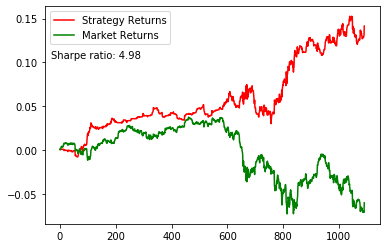

average return 0.003975
[-0.0048219   0.00498342]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.056440000000000046


In [ ]:
eval_model(svc_model)

## DUMMY CLASSIFIER

This section contains the class that implements a baseline model that uniformly and randomly generates decisions, along with the following metrics of its results:

*    market returns, model returns, average returns, Sharpe ratio, White's Reality Check and p-value, as a baseline to compare to the performance of SVC's

In [ ]:
class Dummy(object):
    def __init__(self):
      
        self.df_result = pd.DataFrame(columns=['Actual', 'Predicted'])

    def learn(self, df, ys, start_date, end_date, lookback_period):
        
        model = DummyClassifier(strategy='uniform')
        
        date_index = df["2012":end_date].index
        freq_start = pd.to_datetime(start_date)
        date_range = pd.date_range(start=freq_start, end=end_date,freq='1W')
        
        for i in range(len(date_range)-1):
            
            # get data
            date = date_range[i]
            train_time = pd.to_datetime(str(date) + ' ' + '16:00')
            train_time_index = len(date_index[date_index <= train_time])
            x = self.get_prices_since(df, train_time_index, lookback_period)
            y = self.get_prices_since(ys, train_time_index, lookback_period)
            x = np.array(x)
            y = np.array(y)
            scaler = StandardScaler()
            x = scaler.fit_transform(x)
            
            # fit model
            model.fit(x, y.ravel())
            
            # predict the next week
            pred_time_end = pd.to_datetime(str(date_range[i+1]) + ' ' + '16:00')
            pred_time_index = len(date_index[date_index <= pred_time_end])
            x_current = np.array(df.iloc[train_time_index : pred_time_index].values)
            y_pred = model.predict(scaler.transform(x_current))

            #store predictions
            pred_time = date_index[train_time_index:pred_time_index]
            y_actual = list(ys.loc[pred_time])
            for actual, pred, time in zip(y_actual, y_pred, pred_time):
                self.df_result.loc[time] = [actual, pred]
                
    def get_prices_since(self, df, date_since, lookback):
        return df.iloc[date_since-lookback:date_since]

In [ ]:
dummy_model = Dummy()
dummy_model.learn(X, y, start_date=START, end_date=END, lookback_period=300)

In [ ]:
df_result = dummy_model.df_result
actual = list(df_result['Actual'])
predicted = list(df_result['Predicted'])

print('accuracy_score:', accuracy_score(actual, predicted))
print('precision_score:', precision_score(actual, predicted,average='macro'))
print('recall_score:', recall_score(actual, predicted,average='macro' ))
print('f1_score:', f1_score(actual, predicted,average='macro')) 
print(classification_report(actual, predicted))

accuracy_score: 0.3086080586080586
precision_score: 0.30802022428698805
recall_score: 0.3074568808883705
f1_score: 0.30760849651804306
              precision    recall  f1-score   support

          -1       0.35      0.33      0.34       397
           0       0.30      0.30      0.30       349
           1       0.27      0.29      0.28       346

    accuracy                           0.31      1092
   macro avg       0.31      0.31      0.31      1092
weighted avg       0.31      0.31      0.31      1092



====actual signal counts====
-1    397
 0    349
 1    346
Name: Signal, dtype: int64
====predicted signal counts====
-1    380
 1    366
 0    346
Name: Pred_Signal, dtype: int64


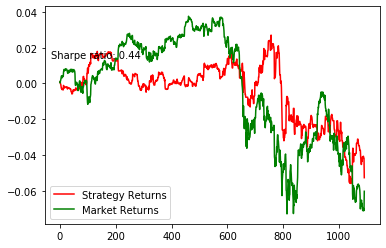

average return -0.000872
[-0.00370874  0.00371127]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.6778


In [ ]:
eval_model(dummy_model)

## Results and Discussion

Comparing between the metrics evaluating returns based on strategies from both dummy classifier and SVM classifier, we conclude:

*    Sharpe Ratio: SVM 4.98 vs. Dummy Classifier 0.44, indicating that SVC-managed portfolio generates attractive returns with respect to risks, while a blindly guessing portfolio results in a loss

*    p-value: SVM 0.056 vs. Dummy Classifier 0.68, indicating that the returns given from SVM are not by chance with a certainty very close to 95%.  

*    SVC's accuracy of 0.4 and F1 score of 0.4 indicating that the model performs satisfactorily, generating average return of 0.4% for the portfolio per 30mins. 